# What is this?

Notebook to help derive the EoM for Centroidal Dynamics for use in a Receding Horizon QP optimization program for force control of a quadruped robot.  This controller will be used for walking, running, recovery and body posing with optimal GRF(Ground Reaction Forces).  We will verify the function of this controller by simulation in PyBullet and V-REP

by Quincy Jones

## Requirements and Dependencies
Numpy, Sympy, CasADi, Gekko, Matplotlib and pyDrake(Possibly?)

## Keywords
* Body Kinematics
* Body CoM Dynamics
* MPC
* Optimization
* CoM Trajectory Optimization, Tracking and Stabilization
* Hybrid Dynamics
* Ground Reaction Forces
* VRep Interface

## Reference Links
CasADi: https://web.casadi.org/docs/

Gekko: https://gekko.readthedocs.io/en/latest/

MIT Cheetah 3 Paper - https://www.researchgate.net/publication/329759867_MIT_Cheetah_3_Design_and_Control_of_a_Robust_Dynamic_Quadruped_Robot

Dynamic Locomotion in the MIT Cheetah 3 Through Convex Model-Predictive Control -
https://www.researchgate.net/publication/330591547_Dynamic_Locomotion_in_the_MIT_Cheetah_3_Through_Convex_Model-Predictive_Control


ETHZ/Towr: https://www.youtube.com/watch?v=KhWuLvb934g

Towr Github: https://github.com/ethz-adrl/towr


In this notebook we will create an optmization to get optimal ground reaction forces to be used in force control for a quadruped robotic platform

Angular Velocity From Euler Angles:
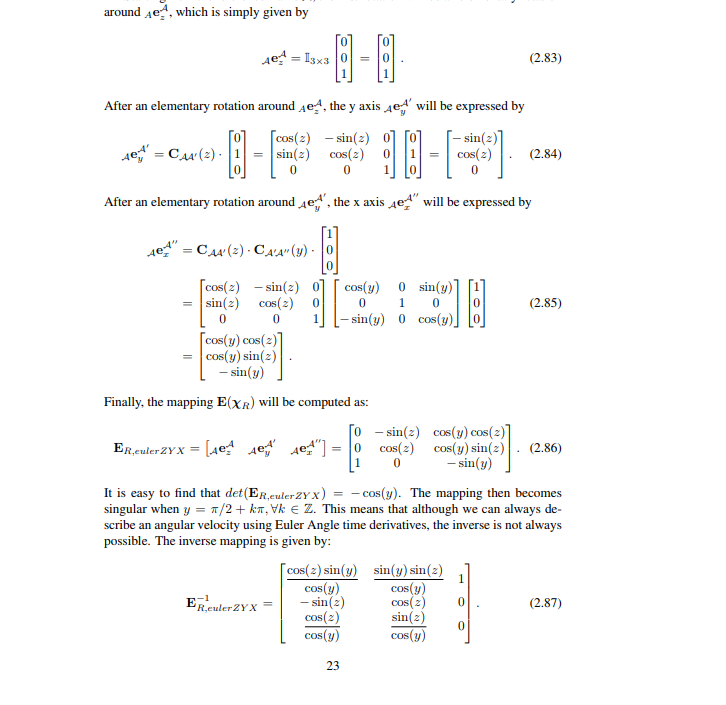

In [13]:
# Notebook setups
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

%matplotlib inline

# Notebook constant terms
gravity = 10

In [14]:
# TODO: Helpers.py blahh
import numpy as np
import scipy as sp
import scipy.linalg as la
import math

# Helper Rotation Matrices

# Rotation Matrix X-Axis (Roll)
def R_x(angle):
    c_th = np.cos(angle)
    s_th = np.sin(angle)
    return np.array([[1, 0, 0],
            [0, c_th, -s_th],
            [0, s_th, c_th]])

# Rotation Matrix Y-Axis (Pitch)
def R_y(angle):
    c_th = np.cos(angle)
    s_th = np.sin(angle)
    return np.array([[c_th, 0, s_th],
            [0, 1, 0],
            [-s_th, 0, c_th]])

# Rotation Matrix Z-Axis (Yaw)
def R_z(angle):
    c_th = np.cos(angle)
    s_th = np.sin(angle)
    return np.array([[c_th, -s_th, 0],
            [s_th, c_th, 0],
            [0, 0, 1]])

# World Space Angular Velocity to Body Space Euler Angle Transformation
def R_omega(phi, theta, psi, linearize = False):
          
    c_phi = np.cos(phi)
    s_phi = np.sin(phi)    
    
    c_th = np.cos(theta)
    s_th = np.sin(theta)
    t_th = np.tan(theta)
                  
    c_psi = np.cos(psi)
    s_psi = np.sin(psi)
    
    # Linearized appoximation for small angles of phi and theta(roll and pitch)
    if linearize == True:
        return np.array([[c_psi, s_psi, 0],
                        [-s_psi, c_psi, 0],
                        [0, 0, 1]]) 
    
    # Return Non-Linear Version
    return np.array([[c_psi/c_th, s_psi/c_th, 0],
                    [-s_psi,      c_psi,      0],
                    [c_psi*t_th,  s_psi*c_th, 1]])
                    #[c_psi/c_th, s_psi/c_th, 1]

# Rotation Transformation Matrix from vector_orig to vector_fin
def R_2vec(R, vector_orig, vector_fin):

    # Convert the vectors to unit vectors.
    vector_orig = vector_orig / np.linalg.norm(vector_orig)
    vector_fin = vector_fin / np.linalg.norm(vector_fin)

    # The rotation axis (normalised).
    axis = np.cross(vector_orig, vector_fin)
    axis_len = np.linalg.norm(axis)
    if axis_len != 0.0:
        axis = axis / axis_len

    # Alias the axis coordinates.
    x = axis[0]
    y = axis[1]
    z = axis[2]

    # The rotation angle.
    angle = math.acos(np.dot(vector_orig, vector_fin))

    # Trig functions (only need to do this maths once!).
    ca = math.cos(angle)
    sa = math.sin(angle)

    # Calculate the rotation matrix elements.
    R[0,0] = 1.0 + (1.0 - ca)*(x**2 - 1.0)
    R[0,1] = -z*sa + (1.0 - ca)*x*y
    R[0,2] = y*sa + (1.0 - ca)*x*z
    R[1,0] = z*sa+(1.0 - ca)*x*y
    R[1,1] = 1.0 + (1.0 - ca)*(y**2 - 1.0)
    R[1,2] = -x*sa+(1.0 - ca)*y*z
    R[2,0] = -y*sa+(1.0 - ca)*x*z
    R[2,1] = x*sa+(1.0 - ca)*y*z
    R[2,2] = 1.0 + (1.0 - ca)*(z**2 - 1.0)

    
# Helper Slicing and indexing for "vector" matrices with a stride
def get_slice(A, row, col, num_rows, num_cols, row_stride = 3, col_stride = 3):
    row_idx = row*row_stride
    col_idx = col*col_stride
    return A[row_idx:row_idx+num_rows, col_idx:col_idx+num_cols]


# Should be able to "get slice" and then set it.  Probably do not need this function
def set_slice(A, row, col, val, row_stride = 3, col_stride = 3):        
    
    row_idx = row*row_stride
    col_idx = col*col_stride

    A[row_idx:row_idx+val.shape[0], col_idx:col_idx+val.shape[1]] = val
    
# https://en.wikipedia.org/wiki/Cross_product#Skew-symmetric_matrix
def cross_product_skew_matrix(vec):
    return np.array([[0,-vec[2],vec[1]],[vec[2],0,-vec[0]],[-vec[1],vec[0],0]])


def vector_normalize(vec):
    
    ret_vec = np.zeros(3)
    length = vector_magnitude(vec)
    
    if(length > 0):
        ret_vec = vec / length
    return ret_vec

def vector_magnitude(vec):
    return np.sqrt(vec.dot(vec))
    
# Remap a range from -> to
def value_map(value, istart, istop, ostart, ostop):
    return ostart + (ostop - ostart) * ((value - istart) / (istop - istart))

# Continuous time to Discrete time zero-order hold method
def c2d_zoh(A, B, Ts):
    # Zero Order Hold Discrate Time Model
    nx = A.shape[0]
    nu = B.shape[1]
    
    # Create Extended Linear System 
    M = np.zeros((nx+nu, nx+nu))
    M[0:nx,0:nx] = A*Ts
    M[0:nx,nx:] = B*Ts
    M_d = la.expm(M) # Convert to Discrete Time

    A_d = M_d[0:nx,0:nx] # Pull out A Matrix
    B_d = M_d[0:nx,nx:] # Pull out B Matrix

    return A_d, B_d

# Helper for plotting on gaits. Divides up a vector based on integer continuity
# [1,2,3,4,5,9,10,11,12] -> [[1,2,3,4,5], [9,10,11,12]]
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)



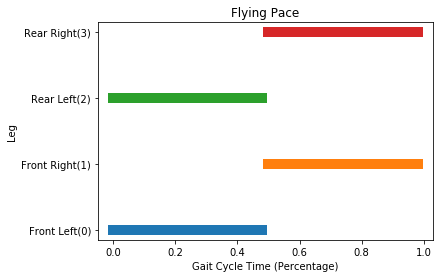

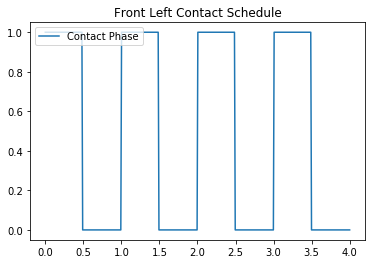

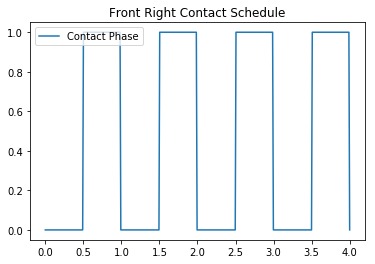

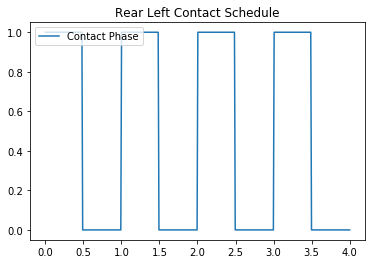

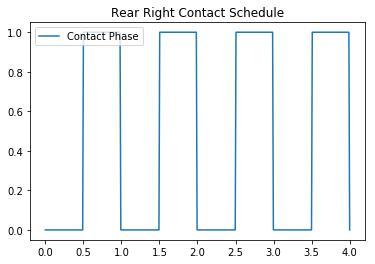

In [15]:
from pylab import plot, step, figure, legend, show, spy, xlabel, ylabel, title, xticks, yticks

# Gait sequencer base class.  Takes in a period, and number of segments
class GaitSequencer:
    def __init__(self, period, segments):
        self.period = period # Period of the gait
        self.freq = 1/period # Frequency of the gait
        self.segments = segments # Number of segments to divide the gait into
        self.leg_phase = [] # Array to hold the leg phase
        self.sync_time = 0.0 # Gait synchronization time.  Probably a better way to do this
        self._setup() # Virtual setup function for subclassed gaits
        self.name = "Gait"
        
        
    def _setup(self):
        raise NotImplementedError()
        
    def start(self, sync_time):
        self.sync_time = sync_time
    
    # Clock in seconds or maybe we do ms
    def get_contact_phases(self, clock):
        
        # Map clock to 0 to 1 to get gait contact phase
        t = (clock - self.sync_time) / self.period
        t = t - int(t)
        
        return self.leg_phase[:,int(t*self.segments)]
      
    # Cool little horizontal line plot of the gait sequency
    def plot(self):
        
        num_legs = self.leg_phase.shape[0]
        yticks(np.arange(4), ('Front Left(0)', 'Front Right(1)', 'Rear Left(2)', 'Rear Right(3)'))
        xlabel("Gait Cycle Time (Percentage)")
        ylabel("Leg")
        title(self.name)
        for i in range(num_legs):
            t_vec = consecutive(np.nonzero(self.leg_phase[i]==1)[0])
            for j in range(len(t_vec)):
                plot(t_vec[j]/self.segments, np.ones(len(t_vec[j]))*(i), linewidth=10.0)


# Trot Gait Sequencer (Opposite diagonal leg pairs are synced)
class TrotGaitSequencer(GaitSequencer):
    
    def __init__(self, period, segments):
        super().__init__(period, segments)
        self.name = "Flying Trot"
        
    def _setup(self):
        # Zero is swing space, One is a stance phase
        self.leg_phase = np.zeros((4, self.segments))
        self.leg_phase[0,0:self.segments//2-16] = 1
        self.leg_phase[0,self.segments//2:-16] = 0
        
        self.leg_phase[1,0:self.segments//2] = 0
        self.leg_phase[1,self.segments//2:-16] = 1
        
        self.leg_phase[2,0:self.segments//2] = 0
        self.leg_phase[2,self.segments//2:-16] = 1
        
        self.leg_phase[3,0:self.segments//2-16] = 1
        self.leg_phase[3,self.segments//2:] = 0
        

# Pace Gait Sequencer (Both lateral sides are synced)
class PaceGaitSequencer(GaitSequencer):
    
    def __init__(self, period, segments):
        super().__init__(period, segments)
        self.name = "Flying Pace"
    def _setup(self):
        # Zero is swing space, #One is a stance phase
        self.leg_phase = np.zeros((4, self.segments))
        self.leg_phase[0,0:self.segments//2-1] = 1
        self.leg_phase[0,self.segments//2:-1] = 0
        
        self.leg_phase[2,0:self.segments//2-1] = 1
        self.leg_phase[2,self.segments//2:-1] = 0
        
        self.leg_phase[1,0:self.segments//2] = 0
        self.leg_phase[1,self.segments//2:-1] = 1
        
        self.leg_phase[3,0:self.segments//2] = 0
        self.leg_phase[3,self.segments//2:-1] = 1
    
# Standing "gait".  Does nothing really but keep all 4 feet in contact.  Seems like a useful thing to keep things consistent.  TBD
class StandingGaitSequencer(GaitSequencer):
    
    def __init__(self, period, segments):
        super().__init__(period, segments)
        self.name = "Standing Gait"
        
    def _setup(self):
        # Zero is swing space, #One is a stance phase
        self.leg_phase = np.ones((4, self.segments))
        
# Test it
gait = PaceGaitSequencer(period = 1.0, segments = 100)
gait.start(0)

gait.plot()



dt = 0.01
fl_contact = []
fr_contact = []
rl_contact = []
rr_contact = []

# 6 seconds
T = 4
for i in range(int(T/dt)): # One Second
    contact = gait.get_contact_phases(i*dt)
    fl_contact.append(contact[0])
    fr_contact.append(contact[1])
    rl_contact.append(contact[2])
    rr_contact.append(contact[3])
    

t_vec = np.linspace(0,T,int(T/dt))


figure()
plot(t_vec, fl_contact,label="Contact Phase")
title('Front Left Contact Schedule')
legend(loc="upper left")

figure()
plot(t_vec, fr_contact,label="Contact Phase")
title('Front Right Contact Schedule')
legend(loc="upper left")

figure()

plot(t_vec, rl_contact,label="Contact Phase")
title('Rear Left Contact Schedule')
legend(loc="upper left")

figure()

plot(t_vec, rr_contact,label="Contact Phase")
title('Rear Right Contact Schedule')
legend(loc="upper left")


In [16]:
#TODO:
# Need Leg Jacobian
# Need foot placement controller
# Update Foot Position Locations Each Step
# MPC Force Constraints
# Trajectory Planner Ramping
# More feasible trajectory planning!, Cubic Polynomials?


# Init Meshcat visualizer
import meshcat
import meshcat.geometry as geom
import meshcat.transformations as tf
import time

# Create a new visualizer
vis = meshcat.Visualizer()

vis.jupyter_cell()



You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [60]:
# Notes
# I_p = Principle Axes of Inertia = [Ixx, Iyy, Izz]
# width is on Body Frame Y Axis
# height is on Body Frame Z Axis
# length is on Body Frame X Axis

import numpy as np

# Prettier printing on the numpy arrays
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# TODO: Needs to be more abstract and virtualized, i.e. Get A, and B Matrix etc
class FloatingBaseRigidBody:
    
    def __init__(self, mass, I_p, width, height, length, Ts = 1e-1, num_forces = 1):
        
        # Mass / Inertia and Gravity
        self.mass = mass           # Body mass [kg]
        self.I_b = np.diag(I_p, 0) # Body Inertia Tensor[kgm^2]
        self.g = gravity              # Gravity [m/s^2]
        
        # Body Geometry, #TODO: Auto calculate I_b?
        self.width = width # Width of Body [m]
        self.height = height # Height of Body [m]
        self.length = length # Length of Body [m]
        
        # Misc. Parameters
        self.num_forces = num_forces # Number of force producing elements, GRFs, Thrusters etc
        self.num_states = 13 # Total number of 6 dof states, xyz positions(+ derivatives), phi, theta, psi(+angular velocities) + augmented gravity
        self.num_inputs = num_forces * 3 # 3D Force Vectors
        
        # State Space Dynamics
        # x = [x,y,z,x',y',z', phi,theta,psi,omega_x,omega_y,omega_z,g].T
        self.A = np.zeros([self.num_states, self.num_states]) #System Matrix
        self.B = np.zeros([self.num_states, self.num_inputs]) #Input Matrix
        self.x = np.zeros((self.num_states,1)) # Body State
        self.x[-1] = self.g # Copy in to the Gravity state
        self.u = np.zeros((self.num_inputs, 1)) # Force Input
        
        self.t = 0 # Current Time
        self.Ts = Ts # Sampling time
        self.rot_body = np.eye(3) # Rotation transformation matrix for Body Orientation
        
        # Default Force Application Positions
        self.p_force = np.zeros([self.num_forces, 3]) # World Frame location of forces
        self.r = np.zeros([self.num_inputs, 3]) # World Frame Force to Torque Vector(CoM -> Force Application Position)
        
        self.force_max = 500
        
        # Meshcat Visualization
        self.vis = None
        
    # CoM Position
    def get_com_pos(self):
        return self.x[0:3].flatten()
    
    # CoM Velocity
    def get_com_vel(self):
        return self.x[3:6].flatten()
    
    # CoM Orientation (Body Frame)
    def get_orientation(self):
        return self.x[6:9].flatten()
    
    # CoM Angular Velocity (World Frame)
    def get_angular_vel(self):
        return self.x[9:12].flatten()
    
    # CoM Position
    def set_com_pos(self, pos):
        self.x[0:3] = pos.reshape(3,-1)
    
    # CoM Velocity
    def set_com_vel(self, vel):
        self.x[3:6] = vel.reshape(3,-1)
    
    # CoM Orientation (Body Frame)
    def set_orientation(self, theta):
        self.x[6:9] = theta.reshape(3,-1)
    
    # CoM Angular Velocity (World Frame)
    def set_angular_vel(self, omega):
        self.x[9:12] = omega.reshape(3,-1)
    
    # World Frame positions of force 
    def set_force_locations(self, force_pos):
        self.p_force = force_pos
    
    # Step simulation
    def step(self):
        raise NotImplementedError()
        
    def init_visualizer(self, vis):
        pass
    
    def render(self):
        pass

# Subclassed floating base for 4 legged quadruped support
class QuadrupedFloatingBase(FloatingBaseRigidBody):
        
    def __init__(self, mass, I_p, width, height, length, Ts = 1e-1):
        super().__init__(mass, I_p, width, height, length, Ts, num_forces = 4)
        
        # Default gait sequencer
        self.gait_sequencer = TrotGaitSequencer(period = 0.5, segments = 100)
        self.gait_sequencer.start(0)
        
    # TODO: Where will the swing leg controller be?
    def update_foot_positions(self, foot_pos):
        
        self.set_force_locations(foot_pos)
        
        # Update Cross Product Vectors
        p = self.get_com_pos()

        self.r[0] = vector_normalize(self.p_force[0]-p)
        self.r[1] = vector_normalize(self.p_force[1]-p)
        self.r[2] = vector_normalize(self.p_force[2]-p)
        self.r[3] = vector_normalize(self.p_force[3]-p)
        
    # R_w = transformation from WCS angular velocity to body pitch, roll and yaw
    # TODO: Add reference docs
    #########################################################
    # A Matrix Form augmented with the gravity term
    # [0_3, 1_3, 0_3,   0_3, 0] = p
    # [0_3, 0_3, 0_3,   0_3, g] = p'
    # [0_3, 0_3, 0_3,   R_w, 0] = theta
    # [0_3, 0_3, 0_3,   0_3, 0] = omega

    # *B Matrix = R^13x3xn where n is number of feet in contant
    # B Matrix Form (I=Body Inertia in World Frame, r_n = CoM->Support Leg vector, m = body mass)
    # [0_3,       0_3,      0_3,        0_3,       0] = p
    # [1_3/m,     1_3/m,    1_3/m,      1_3/m,     0] = p'
    # [0_3,       0_3,      0_3,        0_3,       0] = theta
    # [I^-1[r_1], I^-1[r_2], I^-1[r_3], I^-1[r_4], 0] = omega
    
    ###########################################################
    # Orientation parameter is in format [phi, theta, psi](roll, pitch and yaw)
    def get_A_Matrix(self, orientation, linearize = False):
        
        A = np.zeros((self.num_states, self.num_states))
        R_w = R_omega(phi = orientation[0], theta = orientation[1], psi = orientation[2], linearize = linearize)
        set_slice(A,row=0,col=1,val=np.eye(3)) # Set Identity submatrix
        set_slice(A,row=2,col=3,val=R_w) # Set Rotation submatrix
        A[5,12] = -1 # Augment State Transition for gravity constant term
        return A

    # Orientation parameter is in format [phi, theta, psi](roll, pitch and yaw)
    # TODO: Also need foot placement for this as well
    def get_B_Matrix(self, orientation, contacts = [1,1,1,1], linearize = False):
        
        B = np.zeros((self.num_states, self.num_inputs))
        R = np.eye(3) # Body rotation transform
        
        if linearize is True: # Just the yaw, ignore pitch and roll for better linear approximation
            R = R_z(orientation[2])
        else: # Non linear full body rotation
            R = R_z(orientation[2])*R_y(orientation[1])*R_x(orientation[0])

        I = R*self.I_b*R.T # Transform from body inertia to space frame inertia
        I_inv = np.linalg.inv(I) # Take the inverse and cache it

        # Force application point map
        # TODO: This needs to be passed in as a parameter from foot placement controller(TODO)
        r_nx = [cross_product_skew_matrix(self.r[0]),
               cross_product_skew_matrix(self.r[1]),
               cross_product_skew_matrix(self.r[2]),
               cross_product_skew_matrix(self.r[3])]
        
        # Set Row 2 of the B Matrix
        # Also Augment B with contact states(zero out force inputs for those legs in the air)
        for i in range(self.num_forces):
            set_slice(B,row=1,col=i,val=np.eye(3)/self.mass*contacts[i]) 

        # Set Row 4 of the B Matrix
        # Also Augment B with contact states(zero out force inputs for those legs in the air)
        for i in range(self.num_forces):
            set_slice(B,row=3,col=i,val=I_inv@r_nx[i]*contacts[i]) 
            
        return B
    
    def get_model_matrices(self, state_trajectory = None):
        
        # Return Matrices
        A_d_out = [] # Discrete A
        B_d_out = [] # Discrete B
        A_out = [] # Continuous A (Do we really need this?)
        B_out = [] # Continuous B (Do we really need this?)
        
        if state_trajectory is None: # Use Current State
            
            # Grab the current foot in stance/swing contact states
            contact_state = self.gait_sequencer.get_contact_phases(self.t)
        
            A = self.get_A_Matrix(self.get_orientation(), False)
            B = self.get_B_Matrix(self.get_orientation(), contact_state, False)
            
            # Augment B with contact states(zero out force inputs for those legs in the air)
            #contact = self.gait_sequencer.get_contact_phases(self.t)
            # Set Row 2 of the B Matrix
            #for i in range(self.num_forces):
            #    set_slice(B,row=1,col=i,val=B[3:6, (i*3):(i*3)+3]*contact[i]) 
            
            # Continuous to Discrete Time Conversion
            A_d, B_d = c2d_zoh(A, B, self.Ts)
        
            A_out.append(A)
            B_out.append(B)
            A_d_out.append(A_d)
            B_d_out.append(B_d)
        
        else:
            # Loop over the state trajectory horizon
            for i in range(state_trajectory.shape[1]):
                
                # Grab the current foot in stance/swing contact states
                contact_state = self.gait_sequencer.get_contact_phases(self.t+i*self.Ts)

                # Cache orientations from the current state trajectory/current state
                orientation = state_trajectory[6:9, i]
                A = self.get_A_Matrix(orientation, False)
                B = self.get_B_Matrix(orientation, contact_state, False)
                
                 # Continuous to Discrete Time Conversion
                A_d, B_d = c2d_zoh(A, B, self.Ts)

                # Append to return list
                A_out.append(A)
                B_out.append(B)
                A_d_out.append(A_d)
                B_d_out.append(B_d)
                
        return A_out, B_out, A_d_out, B_d_out
    
    def temp_update_foot_pos(self):
        # Get leg trajectories blah...
        foot_pos = np.empty((self.num_forces,3)) # In the Body Frame
        foot_pos[0] = np.array([self.length/2, -self.width/2, 0]) # F_1 = Front Left Leg Foot Force
        foot_pos[1] = np.array([self.length/2, self.width/2, 0]) # F_2 = Front Right Leg Foot Force
        foot_pos[2] = np.array([-self.length/2, -self.width/2, 0]) # F_3 = Rear Left Leg Foot Force
        foot_pos[3] = np.array([-self.length/2, self.width/2, 0]) # F_4 = Rear Right Leg Foot Force
            
        # Update Foot Positions
        self.update_foot_positions(foot_pos)
        
    # u = [f_1, f_2, f_3, f_4].T
    def step(self, u):
        
        # TODO: Need a "track" parameter to adjust base line foot placements.  This can be useful
        # for say a pace gait to reduce rolling moments by applying forces close to center of mass thus
        # reducing the moments
        
        # Get leg trajectories blah...
        com_p = self.get_com_pos()
        foot_pos = np.empty((self.num_forces,3)) # In the Body Frame
        foot_pos[0] = np.array([self.length/2, -self.width/2, 0]) # F_1 = Front Left Leg Foot Force
        foot_pos[1] = np.array([self.length/2, self.width/2, 0]) # F_2 = Front Right Leg Foot Force
        foot_pos[2] = np.array([-self.length/2, -self.width/2, 0]) # F_3 = Rear Left Leg Foot Force
        foot_pos[3] = np.array([-self.length/2, self.width/2, 0]) # F_4 = Rear Right Leg Foot Force
            
        # Update Foot Positions
        self.update_foot_positions(foot_pos)
        
        # Update Last Control Input
        self.u = u # Current Control Input

        # Need to get the true matrices here without contact state augmenting...
        # Default value for contacts = [1,1,1,1] i.e. full input matrix
        # Controller should have already decided optimal forces.  So here we will use the full plant.
        A = self.get_A_Matrix(self.get_orientation(), False)
        B = self.get_B_Matrix(self.get_orientation(), [1,1,1,1], False)
        
        # Continuous to Discrete Time Conversion
        A_d, B_d = c2d_zoh(A, B, self.Ts)
    
        # Step Simulation
        self.x = A_d@self.x+B_d@self.u
        
        # Update Time
        self.t += self.Ts
        
    # Meshcat Visualizer Intialize
    def init_visualizer(self, vis):
        
        # Setup
        self.vis = vis
        self.vis_robot = vis["robot"]
        self.vis_robot.delete()
        self.vis_body = self.vis_robot["body"]
        self.vis_force = []
        self.vis_foot = []
        
        self.arrow_height = 0.05
        self.foot_sphere_diam = 0.025
        
        # Add Materials
        self.materials = {
            "red": geom.MeshLambertMaterial(color=0xff0000, reflectivity=0.8),
            "green": geom.MeshLambertMaterial(color=0x00ff00, reflectivity=0.8),
            "blue": geom.MeshLambertMaterial(color=0x0000ff, reflectivity=0.8),
            "magenta": geom.MeshLambertMaterial(color=0xff22dd, reflectivity=0.8),     
            "white": geom.MeshLambertMaterial(color=0xeeeeee, reflectivity=0.8),
            "white-trans":geom.MeshLambertMaterial(color=0xeeeeeee, reflectivity=0.8, transparent=True, opacity=0.1)
        }

        # CoM Rigid Body Block
        self.vis_body.set_object(geom.Box([self.length, self.width, self.height]), self.materials["white"])

        for i in range(self.p_force.shape[0]):
            # In a quadruped the force producing elements are the Ground Reaction Forces each foot
            foot = self.vis["robot"]["foot" + str(i)]
            foot.set_object(geom.Sphere(self.foot_sphere_diam), self.materials["magenta"])
            self.vis_foot.append(foot)
            
            # Add some debug for Ground Reaction Forces
            force = vis["robot"]["force" + str(i)]
            force["arrow"].set_object(geom.Cylinder(height=self.arrow_height, radiusTop=0.0,radiusBottom=0.025), self.materials["red"])
            self.vis_force.append(force)
     
    #Meshcat Visualizer Renderer
    def render(self):

        # Get Body Orientation for the transform
        orientation = self.get_orientation()
        
        # Set Body Orientation transform
        body_xform = tf.translation_matrix(self.get_com_pos())
        body_xform = body_xform.dot(tf.euler_matrix(orientation[2],orientation[1],orientation[0],'szyx'))
        self.vis_body.set_transform(body_xform)
  
        # Render Feet and Ground Reaction Forces(GRF)
        for i in range(self.p_force.shape[0]):
            self.vis_foot[i].set_transform(tf.translation_matrix([self.p_force[i, 0],
                                                                  self.p_force[i, 1],
                                                                  self.p_force[i, 2]+self.foot_sphere_diam]))
            # Stride through our last commanded u input vector
            f = self.u[(i*3):(i*3)+3].flatten()
           
            # Get Total GRF Magnitude
            force_mag = vector_magnitude(f)

            if(np.isclose(force_mag, 0.0)): # Zero Force?  If so nothing to draw let's bail
                self.vis_force[i].delete()
                continue
            
            # Normalize the GRF Vector
            f = vector_normalize(f)

            # Rotation transformation for the debug geometry for the GRF
            R = np.eye(4)
            vec1 = np.array([0,1,0]) # Map Y-Axis of cylinder to force axis
            vec2 = np.array(f)
            R_2vec(R, vec1, vec2)
            
            # Scale GRF magnitude and map to a better range for debug
            force_mag = value_map(force_mag, -self.force_max,self.force_max,-0.5,0.5)
            
            # Compute GRF transform, translate to force position and orient to force direction
            force_xform = tf.translation_matrix([self.p_force[i,0],self.p_force[i,1],0])
            force_xform = force_xform.dot(R)
            force_xform = force_xform.dot(tf.translation_matrix([0.0,-force_mag*0.5-.02,0]))

            # Draw the debug GRF
            self.vis_force[i].set_transform(force_xform)
            self.vis_force[i].set_object(geom.Cylinder(height=force_mag, radius=0.01,),
                                        self.materials["red"])
            self.vis_force[i]["arrow"].set_object(geom.Cylinder(height=self.arrow_height, radiusTop=0.0,radiusBottom=0.025), self.materials["red"])
            self.vis_force[i]["arrow"].set_transform(tf.translation_matrix([0,force_mag*0.5,0]))
                            

                
# Sample test
Ts = 1e-2
nomad = QuadrupedFloatingBase(mass=44, I_p=[0.41,2.1,2.1], width=400e-3, height=200e-3, length= 600e-3, Ts=Ts)
nomad.init_visualizer(vis)

# Initial Condition
nomad.set_com_pos(np.array([0,0,0.8]))
nomad.set_angular_vel(np.array([0.0,0.0,0.0]))
nomad.t = 0.0

# Enough force to counteract gravity.
u = np.array([[0,0,110,0,0,110,0,0,110,0,0,110]]).T

for i in range(500):
   # Test Render
    nomad.step(u)
    nomad.render()
    time.sleep(Ts)
    



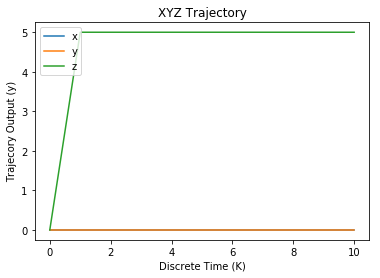

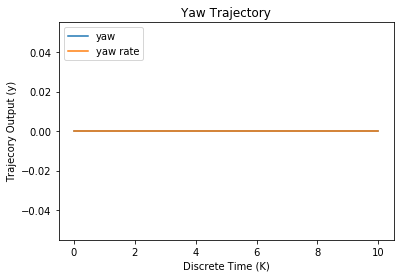

In [18]:

class CoMTrajectoryGenerator:
    """
    Single Rigid Body Center of Mass trajectory generator class for use in a MPC controller.

    ...

    Attributes
    ----------
    T : float
        The length in time(seconds) of the generated trajectories
    N : int
        The desired number of sample points to divide the trajectory into
    dt : float
        The discrete time interval of evaluation
    num_states : int
        Number of states in the trajectory
    x : Holds the trajecotry states
    
    Methods
    -------
    generate(x0, x_dot, y_dot, yaw_dot, z_com, z_dot=0)
        Generates a reference trajectory
    plot()
        Plots computed reference trajecoty
    """
        
    # State = [x,y,z,x',y',z', phi, theta, psi, omega_x, omega_y, omega_z].T
    def __init__(self, length = 1.0, sample_points = 10):
        """
        Parameters
        ----------
        length : float
            The length in time(seconds) of the generated trajectories
        sample_points : int
            The desired number of sample points to divide the trajectory into
        """
        self.T = length
        self.N = sample_points
        self.dt = self.T/self.N
        self.num_states = 13 # Is this to be variable??
        self.x = np.zeros((self.num_states, (self.N+1)))

    # This is for walking/running input
    def generate(self, x0, x_dot, y_dot, yaw_dot, z_com, z_dot=0):
        """
        Parameters
        ----------
        x0 : float[self.num_states]
            Initial Conditions of trajectory
        x_dot : float
            The desired World Frame x velocity
        y_dot : float
            The desired World Frame y velocity
        yaw_dot : float
            The desired yaw turning rate
        z_com : float
            The desired CoM Z Height of trajectory

        """
        
        
        # Everything below works "okay" but really need better feasible trajectories here with 
        # constraints and bounds on time/velocity/accel/jerk for smoothness.  For now we just do a linear state space
        # hack job
        self.x[:, 0] = x0 # Update initial state
        
        # Fill in controller values to integrate out the trajectory
        self.x[2, 1] = z_com # Desired Z CoM height
        self.x[3, 1] = x_dot # Desired X CoM velocity 
        self.x[4, 1] = y_dot # Desired Y CoM velocity
        #self.x[5, 1] = z_dot # Desired Z CoM velocity
        self.x[11,1] = yaw_dot # Desired Yaw rate CoM Body Orietation (Conveniently this is omega_z*1.  We CANNOT do this in general)
        self.x[12,1]= gravity # Gravity State
        A = np.zeros((self.num_states, self.num_states))
        A[0, 3] = 1
        A[1, 4] = 1
        A[2, 5] = 1
        
        # TODO: Need to have body velocities to angular
        A[6,  9]= 1
        A[7, 10] = 1
        A[8, 11] = 1

        # TODO: Body rotation velocities to omega world?
        # Discrete?
        # TODO: Need R from current state -> next time state
        # 
        # TODO: Need to cache A matrices over entire trajectory as it is time varying potentially
        for i in range(1, self.N):
            self.x[:, i+1] = self.x[:,i] + A@self.x[:,i] * self.dt
            self.x[12, i+1] = gravity
        return self.x
    
    
    # TODO: Body pose trajecories with limits        
    def plot(self):
        from pylab import plot, step, figure, legend, show, spy, xlabel, ylabel, title

        plot(self.x[0,:],label="x")
        plot(self.x[1,:],label="y")
        plot(self.x[2,:],label="z")
        xlabel('Discrete Time (K)')
        ylabel('Trajecory Output (y)')
        title('XYZ Trajectory')

        #plot(t_vec, sol.value(X[5,:]),label="v")
        legend(loc="upper left")
        figure()
        
        plot(self.x[8,:],label="yaw")
        plot(self.x[11,:],label="yaw rate")
        xlabel('Discrete Time (K)')
        ylabel('Trajecory Output (y)')
        title('Yaw Trajectory')

        legend(loc="upper left")

        
# Sample Test
N = 10
num_states = 13
ctg = CoMTrajectoryGenerator(length = 1.0, sample_points=N)
x_init = np.array(np.zeros(num_states))
y = ctg.generate(x_init, x_dot = 0, y_dot = 0, yaw_dot = 0, z_com = 5)
ctg.plot()
        

sim_step= 0


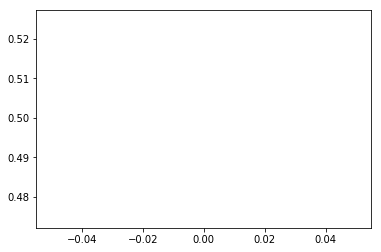

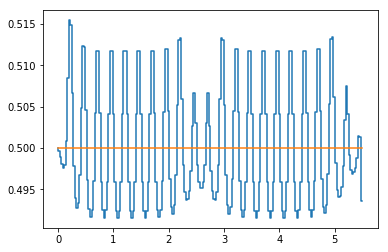

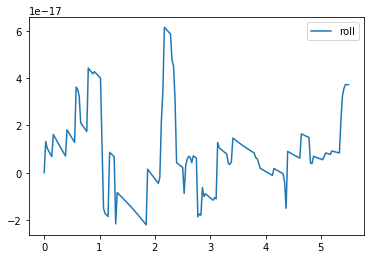

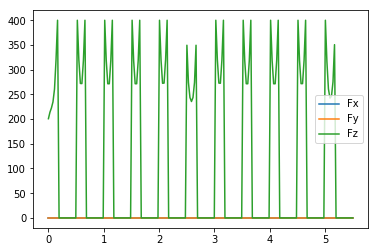

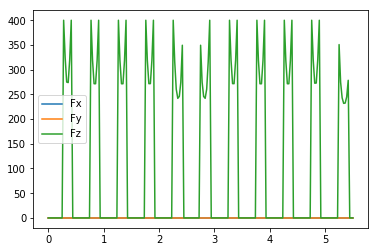

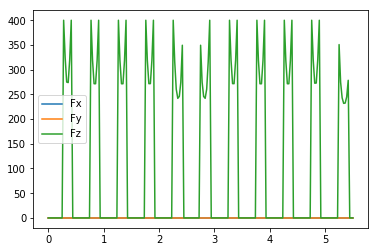

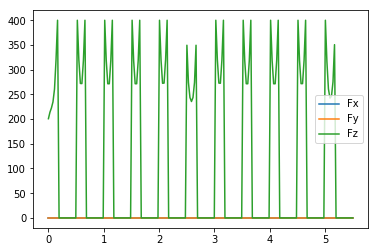

In [61]:

# MPC Optimization Portion

from casadi import *
import numpy as np

# Setup Better Debug Array Printing
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180

np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

# Model Params

"""
m = 20 # Body Mass
m_inv = 1/m

# Moment of Inertia at Center of Mass   (kg m^2)
Ixx = 0.397
Ixy = -2.788E-05
Ixz = -1.469E-07
Iyx = -2.788E-05
Iyy = 0.098
Iyz = 6.494E-07
Izx = -1.469E-07
Izy = 6.494E-07
Izz = 0.454

"""

    
# Setup our prediction horizons
# Note: Bumping up the predicion horizon for now because it runs faster and easier to debug ATM
# TODO: Fix the NLP solver iterations.  We are setting up the problem everytime ATM
K = 200 # Prediction Steps (16 Steps is ideal)
T = 5.5 # Horizon Length (seconds) (0.5 second ideal window)
dt = T/K # Time step

t_vec = np.linspace(0,T,K+1) # Plotting time vector

# Setup our Plants:
# We create 2 plants here:
# One for rolling out the MPC simulations for optimization.
# Other is for time stepping the actual plant with the output from the MPC.  The true estimated state is then fed back
# as the initial condition to the next run of the MPC.  Right now it is simulated as I have no "real" quad plant yet :P

# Plant for MPC Rollouts
nomad_mpc = QuadrupedFloatingBase(mass=44, I_p=[0.41,2.1,2.1], 
                                  width=400e-3, 
                                  height=200e-3, 
                                  length= 600e-3, 
                                  Ts=dt)
# Actual plant
nomad_plant = QuadrupedFloatingBase(mass=44, I_p=[0.41,2.1,2.1], 
                                  width=400e-3, 
                                  height=200e-3, 
                                  length= 600e-3, 
                                  Ts=dt)

# Init the visualizer for the plant
nomad_plant.init_visualizer(vis)


# Setup our dynamics constraint callback function
f = lambda A,B,x,u: A@x+B@u #dx/dt = f(x,u)

# State and Input Weighting

# Higher weight on our Z position.  Everything else equal.  Maybe higher weights on some of the body
# Orientation to help different gaits?
Q = np.diag(np.array([1,1,50,1,1,1,1,1,1,1,1,1,1])) # State Weighting

alpha = 1e-6
R = np.eye(nomad_mpc.num_inputs)*alpha # Input Weighting

# Initial Condition
nomad_plant.set_com_pos(np.array([0.0,0.0,0.5]))
nomad_plant.set_orientation(np.array([0.0,0.0,0.0]))
nomad_plant.set_angular_vel(np.array([0.0,0.0,0.0]))

# Copy over to the MPC plant
nomad_mpc.x = nomad_plant.x
initial_state = nomad_plant.x

###### HACKED ###############
###### TODO: Needs to come from something smart like a swing leg controller.  Is not getting updated in the trajectory!!! ###
###### Since we are just trying to stay in place at the moment do a shitty hack
######
nomad_plant.temp_update_foot_pos()
nomad_mpc.temp_update_foot_pos()

# CoM Trajectory generator.  Match horizon length and sample points
ctg = CoMTrajectoryGenerator(length = T, sample_points=K)

# How many steps to simulate
sim_steps = 1

# Vectors for caching output
z_vec = []
u_vec = []

# Setup Casadi
opti = Opti() # Optimization problem

# Print and debug options
p_opts = {"print_time":False}
s_opts = {"print_level":1, "max_iter":50}

# Using ipopt non linear solver.  May do qpOases as full quadratic for increased frequency
opti.solver('ipopt', p_opts, s_opts)

#### Note: We are actually setting up the NLP every iteration, thus wasting some time.  Nee to use parameters and just step
### The optimization after an initial setup
### opti.parameter() and opti.set_value() blah
for i in range(sim_steps):
    
    print("sim_step=", i)
    
    # Decision Variables.  This should be able to be pulled outside of this loop.
    X = opti.variable(nomad_mpc.num_states,K+1) # State Vector = [x,y,z,x',y',z', phi, theta, psi, omega_x, omega_y, omega_z].T
    U = opti.variable(nomad_mpc.num_inputs,K+1) # Input Vector = [f1_x, f1_y, f1_z,...,fn_x,fn_y,fn_z].T

    # Pull out state vectors into some variables. Numpy notation = a:b = from a+1 to b
    p_hat = X[0:3,:]# CoM Position
    p_hat_d = X[3:6,:] # CoM Velocity
    Theta_hat = X[6:9,:] # CoM Orientation
    omega_hat = X[9:12,:] # CoM Angular Velocity
    g = X[12, :] # Gravity Term
    g = nomad_mpc.g

    # Pull out input forces vectors into some variables.  Numpy notation = a:b = from a+1 to b
    f_1 = U[0:3,:]  # F_1 = Front Left Leg Foot Force
    f_2 = U[3:6,:]  # F_2 = Front Right Leg Foot Force
    f_3 = U[6:9,:]  # F_3 = Rear Left Leg Foot Force
    f_4 = U[9:12,:] # F_4 = Read Right Leg Foot Force

    # Copy over to the MPC plant for next iteration
    nomad_mpc.x = nomad_plant.x
    
    # Sync times
    nomad_mpc.t = nomad_plant.t

    ###### HACKED ###############
    ###### TODO: Needs to come from something smart like a swing leg controller.  Is not getting updated in the trajectory!!! ###
    ###### Since we are just trying to stay in place at the moment do a shitty hack
    ######
    nomad_plant.temp_update_foot_pos()
    nomad_mpc.temp_update_foot_pos()
    
    # Generate Trajectories
    y = ctg.generate(nomad_mpc.x.flatten(), x_dot = 0, y_dot = 0, yaw_dot = 0, z_com = 0.5)
    
    # Path constraints for initial conditions
    opti.subject_to(X[:,0] == nomad_mpc.x) # Needs to be a a param
    
    # Input constraint
    # TODO: This needs to include friction, etc.
    opti.subject_to(opti.bounded(-400,U,400)) # Still need friction constraints

    # Get model matrices over reference trajectory horizon
    _, _, A_hat, B_hat = nomad_mpc.get_model_matrices(y)
    
    # Setup our cost summation here so we can set it up in just one loop.  This should be a one time thing out of the main
    # MPC loop
    J = 0

    # Dynamics (Multiple Shooting)
    for n in range(K):
        
        opti.subject_to(X[:, n+1] == f(A_hat[n],B_hat[n],X[:, n], U[:, n])) # Discrete Time
        #opti.subject_to(X[:, n+1] == X[:, n] + f(A_hat,B_hat,X[:, n], U[:, n])*dt) # Continuous Time
        
        # Update our cost.  Minimize error between state and reference trajectory and Minimize input force
        error = X[:, n+1] - y[:, n+1]
        J += (error.T@Q@(error) + U[:, n].T@R@(U[:, n]))

    # Minimize our objective
    opti.minimize(J)

    # Solve it
    sol = opti.solve()

    # Update our next iteration initial guess
    opti.set_initial(U, sol.value(U));
    opti.set_initial(X, sol.value(X));
    
    # Get the optimizaed u vector. We use only the first optimial control input. Will update again next
    # time step
    u = sol.value(U[:,0]).reshape(-1,1)
    
    # Step our plant with the computed input
    nomad_plant.step(u)
    
    # Cache some values for plotting and simulation later
    u_vec.append(u)
    z_vec.append(nomad_plant.get_com_pos()[2])
    nomad_plant.render()

# Reset our plant
nomad_plant.t = 0
nomad_plant.x = initial_state

# Render the output
for i in range(sim_steps):
    nomad_plant.step(u_vec[i])
    nomad_plant.render()
    time.sleep(dt)

# Render the MPC output
# Note: This only has data from the last sim step run so isn't the ENTIRE trajectory.
# Useful if you want to sim a longer trajectory quickly and render here without doing the stepping
for i in range(K+1):
    u = sol.value(U[:,i]).reshape(-1,1)
    nomad_plant.step(u)
    nomad_plant.render()
    time.sleep(dt)
           
# Graph the output
# Note: This only has data from the last sim step run so isn't the ENTIRE trajectory.
# Would need to save the state of all these values to plot the full trajectory.
from pylab import plot, step, figure, legend, show, spy

figure()
plot(z_vec)

figure()
step(t_vec, sol.value(X[2,:]),label="z com")
#plot(t_vec, sol.value(y[0,:]),label="z_t")
#plot(t_vec, sol.value(y[3,:]),label="zd_t")
plot(t_vec, sol.value(y[2,:]),label="z com desired")


figure()
plot(t_vec, sol.value(X[6,:]),label="roll")
legend(loc="best")

figure()
plot(t_vec, sol.value(f_1[0,:]),label="Fx")
plot(t_vec, sol.value(f_1[1,:]),label="Fy")
plot(t_vec, sol.value(f_1[2,:]),label="Fz")
legend(loc="best")
#step(t_vec,sol.value(f_1[2,:]),'k',label="Fz1")

figure()
plot(t_vec, sol.value(f_2[0,:]),label="Fx")
plot(t_vec, sol.value(f_2[1,:]),label="Fy")
plot(t_vec, sol.value(f_2[2,:]),label="Fz")
legend(loc="best")
#step(t_vec,sol.value(f_2[2,:]),'k',label="Fz2")

figure()
plot(t_vec, sol.value(f_3[0,:]),label="Fx")
plot(t_vec, sol.value(f_3[1,:]),label="Fy")
plot(t_vec, sol.value(f_3[2,:]),label="Fz")
legend(loc="best")
#step(t_vec,sol.value(f_3[2,:]),'k',label="Fz3")

figure()
plot(t_vec, sol.value(f_4[0,:]),label="Fx")
plot(t_vec, sol.value(f_4[1,:]),label="Fy")
plot(t_vec, sol.value(f_4[2,:]),label="Fz")
legend(loc="best")
#step(t_vec,sol.value(f_4[2,:]),'k',label="Fz4")



In [62]:
# This section just renders last output without going through the solver
nomad_plant.x = initial_state
nomad_plant.t = 0.
for i in range(sim_steps):
    #u = sol.value(U[:,i]).reshape(-1,1)
    nomad_plant.temp_update_foot_pos()
    nomad_plant.step(u_vec[i])
    nomad_plant.render()
    time.sleep(dt)
    
    
    

In [63]:
# This section just renders last output without going through the solver
nomad_plant.x = initial_state
nomad_plant.t = 0
for i in range(K+1):
    u = sol.value(U[:,i]).reshape(-1,1)
    nomad_plant.step(u)
    nomad_plant.render()
    time.sleep(dt)